In [6]:
from diffractio import degrees, mm, plt, um
from diffractio.scalar_sources_X import Scalar_source_X
from diffractio.scalar_masks_X import Scalar_mask_X
from diffractio.scalar_masks_XZ import Scalar_mask_XZ
from diffractio.utils_optics import field_parameters
from diffractio.utils_drawing import draw_several_fields
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time, datetime
from tqdm import tqdm
import pickle

template = "plotly_dark"
from matplotlib import rcParams

rcParams["figure.dpi"] = 75

# change matplotlib template to light
plt.style.use("default")


def time_now():
    return datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")


In [3]:
wavelength = 0.6238 * um
n_bins = 500
# field_x = 10
width_x = 50
x0 = np.linspace(-width_x * um, width_x * um, n_bins)

# plane wave
u0 = Scalar_source_X(x=x0, wavelength=wavelength)
u0.plane_wave(A=1, theta=0)
t0 = Scalar_mask_X(x=x0, wavelength=wavelength)


# Barrier

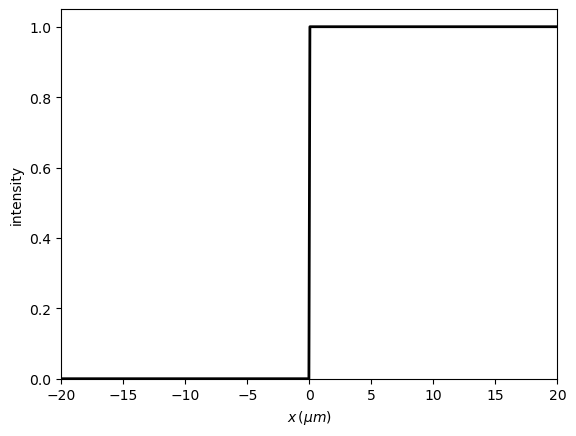

In [6]:
barrier_type = 'single_slit'
slit_width = 50

t0.two_levels(level1=0, level2=1, x_edge=0)

# t0.slit(x0=field_x // 2, size=slit_width * um)
# t0.two_levels(level1=0, level2=2)
t0.draw("intensity")

u1 = u0 * t0


# One Slit

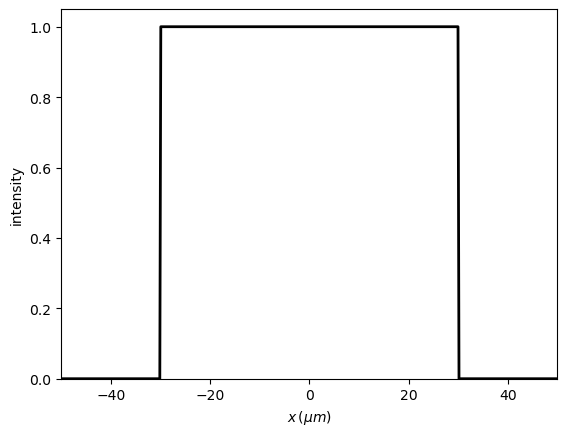

In [4]:
barrier_type = 'single_slit'
slit_width = 60


t0.slit(x0=0, size=slit_width * um)
# t0.two_levels(level1=0, level2=2)
t0.draw("intensity")

u1 = u0 * t0


# Double Slits

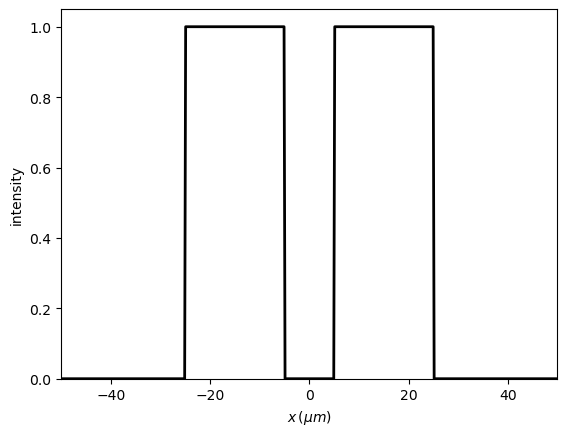

In [3]:
barrier_type = "double_slit"
slit_width = 20
slit_separation = 30
t0.double_slit(x0=0, size=slit_width * um, separation=slit_separation * um)
t0.draw("intensity")

u1 = u0 * t0

# Create Field

In [9]:
intensities = {}
AMPLIFICATION = 1
# Propagation a certain distance and draw
for z in tqdm([1, 10, 100, 250, 500, 1_000, 2000, 3_000]):
    u = u1.RS(
        z=z * um, new_field=True, verbose=True, amplification=AMPLIFICATION
    )
    # u.draw(kind="intensity")
    intensities[z] = np.abs(u1.RS(
        z=z * um, matrix=True, verbose=True, amplification=AMPLIFICATION
    )) ** 2
    # save pickle file intensitiy_z
    with open(f"intensity_{z}.pkl", "wb") as f:
        pickle.dump(intensities, f)



100%|██████████| 8/8 [00:00<00:00, 1177.89it/s]

Good result: factor 2.20
Good result: factor 2.20
Good result: factor 2.24
Good result: factor 2.24
Good result: factor 4.87
Good result: factor 4.87
Good result: factor 10.90
Good result: factor 10.90
Good result: factor 20.90
Good result: factor 20.90
Good result: factor 39.64
Good result: factor 39.64
Good result: factor 72.99
Good result: factor 72.99
Good result: factor 102.39
Good result: factor 102.39


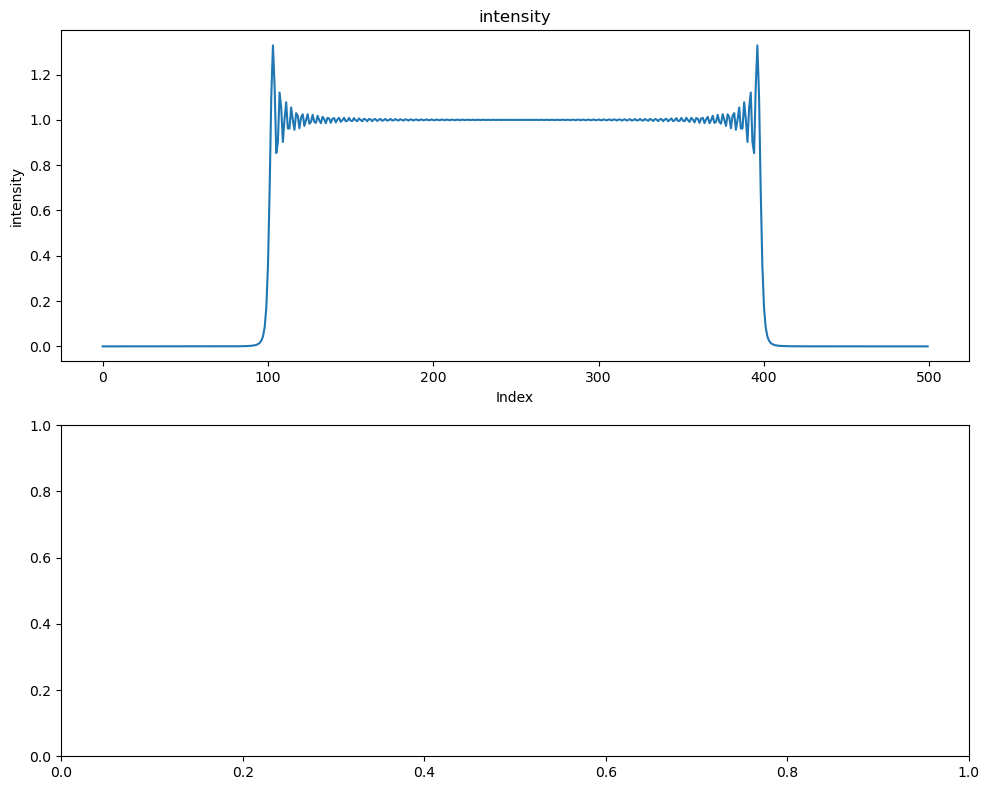

In [11]:
# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Magnitude plot
axs[0].plot(intensities[1])
axs[0].set_title('intensity')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('intensity')

plt.tight_layout()
plt.show()

In [5]:
def get_RS(u1, um, threshold, close_step, far_step, max_z):
    z_distances = []
    z_value = 1
    step = close_step

    while z_value <= max_z:
        u_ = u1.RS(z=z_value * um, new_field=True, verbose=False)
        _, intensity, _ = field_parameters(u_.u)

        z_distances.append(np.column_stack((np.ones_like(u_.x) * z_value, u_.x, intensity)))

        if z_value >= threshold:
            step = far_step

        if z_value == 1:
            z_value -= 1
        z_value += step

    grid = pd.DataFrame(np.vstack(z_distances)).rename(columns={0: "y", 1: "x", 2: "z"})
    grid["x"] = grid.x.round(2)
    y_np = pd.pivot_table(grid, values="z", index="y", columns="x")
    y_np = y_np.div(y_np.max().max())
    return grid, y_np


In [7]:
grid, y_np = get_RS(u1, um, threshold=500, close_step=10, far_step=100, max_z=1000)

In [8]:
grid

,y,x,z
0,1.0,-50.0,2.462134e-07
1,1.0,-49.8,2.488899e-07
2,1.0,-49.6,2.516068e-07
3,1.0,-49.4,2.543649e-07
4,1.0,-49.2,2.571650e-07
...,...,...,...
27995,1000.0,49.2,2.056868e-01
27996,1000.0,49.4,2.038817e-01
27997,1000.0,49.6,2.026778e-01
27998,1000.0,49.8,2.020215e-01


In [9]:
y_np

x,-50.0,-49.8,-49.6,-49.4,-49.2,-49.0,-48.8,-48.6,-48.4,-48.2,...,48.2,48.4,48.6,48.8,49.0,49.2,49.4,49.6,49.8,50.0
y,,,,,,,,,,,,,,,,,,,,,
1.0,1.555600e-07,1.572511e-07,1.589677e-07,1.607103e-07,1.624794e-07,1.642756e-07,1.660993e-07,1.679512e-07,1.698317e-07,1.717415e-07,...,0.570346,0.665280,0.708276,0.570842,0.538978,0.726146,0.839877,0.698480,0.437740,0.227077
10.0,2.012687e-05,2.036896e-05,2.060803e-05,2.084378e-05,2.107586e-05,2.130392e-05,2.152761e-05,2.174656e-05,2.196040e-05,2.216874e-05,...,0.824983,0.773138,0.690862,0.591561,0.506798,0.422454,0.338970,0.276440,0.224812,0.175421
20.0,5.679816e-05,5.439453e-05,5.182751e-05,4.912675e-05,4.632554e-05,4.346057e-05,4.057171e-05,3.770167e-05,3.489564e-05,3.220075e-05,...,0.617739,0.542912,0.493511,0.432439,0.363759,0.319827,0.281802,0.232749,0.196521,0.175393
30.0,3.256451e-05,3.067985e-05,3.134121e-05,3.465927e-05,4.063380e-05,4.914585e-05,5.995485e-05,7.270126e-05,8.691524e-05,1.020315e-04,...,0.492920,0.461412,0.413840,0.352069,0.315059,0.291705,0.251281,0.210633,0.192100,0.176040
40.0,8.958597e-05,6.808917e-05,5.303140e-05,4.614724e-05,4.849340e-05,6.030552e-05,8.092406e-05,1.088025e-04,1.416049e-04,1.763905e-04,...,0.455013,0.404135,0.347944,0.320229,0.303428,0.267006,0.224892,0.204621,0.195529,0.172498
50.0,5.764873e-05,6.217745e-05,8.657025e-05,1.281425e-04,1.815466e-04,2.394300e-04,2.934435e-04,3.354718e-04,3.589092e-04,3.597828e-04,...,0.408616,0.379711,0.328987,0.287616,0.272430,0.261155,0.231178,0.194562,0.175467,0.171396
60.0,1.154970e-04,1.824992e-04,2.645456e-04,3.464541e-04,4.124872e-04,4.494689e-04,4.495682e-04,4.121546e-04,3.442794e-04,2.595879e-04,...,0.381860,0.357228,0.312098,0.270909,0.253071,0.247898,0.231486,0.199240,0.169877,0.158566
70.0,1.137153e-04,1.933892e-04,3.010237e-04,4.128794e-04,5.034049e-04,5.512191e-04,5.444059e-04,4.837990e-04,3.833340e-04,2.672025e-04,...,0.342172,0.335679,0.314732,0.276200,0.238437,0.219067,0.215511,0.209595,0.188946,0.160026
80.0,2.536477e-04,1.472700e-04,9.411267e-05,1.099050e-04,1.929912e-04,3.240851e-04,4.706617e-04,5.950692e-04,6.643893e-04,6.594815e-04,...,0.346187,0.302373,0.267571,0.252522,0.249929,0.242716,0.220766,0.189758,0.164489,0.154234


# Plots

In [10]:
fig = go.Figure(
    data=[
        go.Surface(
            x=y_np.columns.values,
            z=y_np.values,
            y=y_np.index.values,
            showscale=False,
            hoverinfo=None,
            name="1slit",
            lighting=dict(
                diffuse=0.0, specular=0.0, fresnel=0.0, roughness=0.0
            ),
            # colorscale=["red", "black"],
            colorscale="Turbo",
            reversescale=True,
            contours_z=dict(
                project_x=False,
                project_y=False,
                project_z=False,
                highlight=True,
                highlightcolor="red",
                highlightwidth=1,
            ),
            contours_y=dict(
                highlightcolor="red",
                project_y=True,
                project_z=False,
                project_x=False,
                highlight=True,
                width=1,
                highlightwidth=1,
                show=False,
            ),
            contours_x=dict(
                highlightcolor="red",
                project_x=True,
                project_y=False,
                project_z=False,
                highlight=False,
                width=16,
                show=False,
                highlightwidth=1,
            ),
        )
    ],
)
fig.update_layout(template=template)
fig.update_layout(
    scene=dict(
        xaxis_showspikes=False,
        yaxis_showspikes=False,
        zaxis_showspikes=False,
        xaxis_visible=False,
        yaxis_visible=False,
        zaxis_visible=False,
        yaxis_range=[
            y_np.index.to_numpy().min(),
            y_np.index.to_numpy().max() * 1.5,
        ],
    ),
    margin=dict(t=0, b=0, l=0, r=0),
)
# keep 3d aspect ratio
fig.update_layout(scene_aspectmode="manual")
fig.update_layout(scene_aspectratio=dict(x=1, y=4, z=1))
fig.write_html(f"plotly_graphs/diffractio/slit_3D_research.html")
# fig.write_html(f"plotly_graphs/diffractio/slit_3D_{time_now()}.html")
fig.show(renderer="browser")

fig = go.Figure()
fig.add_trace(
    go.Heatmap(
        x=y_np.columns.values,
        z=y_np.values,
        y=y_np.index.values,
        reversescale=True,
        colorscale="Turbo",
    )
)
fig.update_layout(template=template)
# keep aspect ratio
fig.update_xaxes(scaleanchor="y", scaleratio=10)

fig.update_layout(
    margin=dict(t=50, b=0, l=0, r=0),
)
fig.write_html(f"plotly_graphs/diffractio/slit_heatmap_research.html")
fig.show(renderer="browser")
# fig.write_html(f"plotly_graphs/diffractio/slit_heatmap_{time_now()}.html")


## Plots outdated

In [12]:
fig = px.line(
    grid,
    x="x",
    y="y",
    animation_frame="z",
    animation_group="y",
    template=template,
    color_discrete_sequence=["crimson", "blue"],
)
fig.write_html(f"plotly_graphs/diffractio/timescatter_{time_now()}.html")
fig.show(renderer="browser")


In [13]:
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=z_distance[z][:, 1],
            z=z_distance[z][:, 2],
            y=z_distance[z][:, 0],
            name="1slit",
            mode="lines",
            marker_size=1,
            marker_color="crimson",
            # opacity=0.1,
            line_width=2,
        )
        for z in range(len(z_distance))
    ],
    layout=dict(width=800, height=800),
)
# fig.for_each_trace(
#     lambda trace: trace.update(
#         colorscale=["black", "red"],
#         reversescale=False,
#         contours_z=dict(usecolormap=False, project_z=False),
#         contours_y=dict(highlightcolor="red", project_y=True),
#     )
#     if trace.name == "1slit"
#     else (),
# )
fig.update_layout(template=template)
fig.update_layout(
    scene=dict(
        xaxis_showspikes=False,
        yaxis_showspikes=False,
        zaxis_showspikes=False,
        xaxis_visible=False,
        yaxis_visible=False,
        zaxis_visible=False,
    ),
    margin=dict(t=0, b=0, l=0, r=0),
)
fig.write_html(f"plotly_graphs/diffractio/3d_scatter_{time_now()}.html")
fig.show(renderer="browser")


NameError: name 'z_distance' is not defined